# Flux Divergence Calculations
## Ngozumpa Glacier Example
David Shean  
April 21, 2020

Data for Ngozumpa with Nov 8, 2018 timestamp - earlier run of mb_parallel.py

In [1]:
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt
import scipy.stats
from matplotlib_scalebar.scalebar import ScaleBar

In [2]:
#%matplotlib notebook

In [3]:
def imshow_stretch(ax,a,perc=(2,98),sym=False,cmap='inferno'):
    vmin,vmax = np.percentile(a.compressed(),perc)
    if sym:
        vmax = np.max(np.abs([vmin,vmax]))
        vmin = -vmax
        cmap = 'RdBu'
    m = ax.imshow(a, vmin=vmin, vmax=vmax, cmap=cmap)
    ax.add_artist(ScaleBar(30))
    plt.colorbar(m, ax=ax)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_facecolor('0.5')

In [4]:
def add_quiver(ax, vx, vy, stride=10, color='dodgerblue'):
    X = np.arange(0,vx.shape[1],stride)
    Y = np.arange(0,vx.shape[0],stride)
    ax.quiver(X, Y, vx[::stride,::stride], vy[::stride,::stride], color=color, pivot='mid')

In [5]:
H_fn = '15.03473_H.tif'
H_ds = rio.open(H_fn)
H = rio.open(H_fn).read(1, masked=True)

In [8]:
vx_fn = '15.03473_vx.tif'
vy_fn = '15.03473_vy.tif'
vx = rio.open(vx_fn).read(1, masked=True)
vy = rio.open(vy_fn).read(1, masked=True)
vm = np.sqrt(vx*vx + vy*vy)

In [9]:
h_fn = '15.03473_z2.tif'
h = rio.open(h_fn).read(1, masked=True)

In [6]:
#Raster cell size in meters
dx,dy = H_ds.res

In [37]:
#Scaling factor to obtain column-average velocity from surface velocity
v_col_f = 0.8

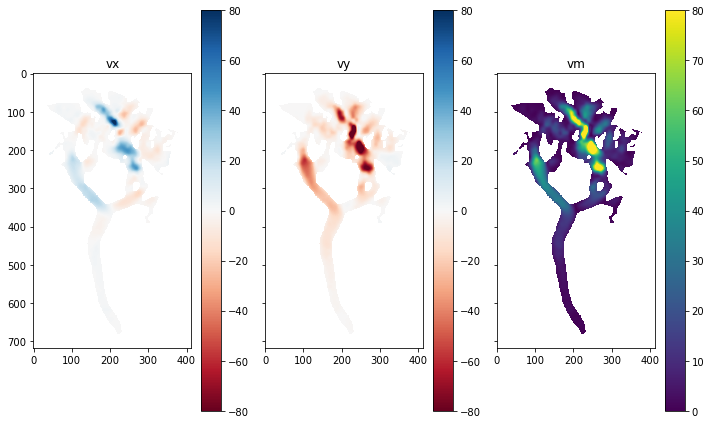

In [10]:
f,axa = plt.subplots(1,3,sharex=True,sharey=True,figsize=(10,6))
lim = 80
m = axa[0].imshow(vx, vmin=-lim, vmax=lim, cmap='RdBu')
axa[0].set_title('vx')
plt.colorbar(m, ax=axa[0])
m = axa[1].imshow(vy, vmin=-lim, vmax=lim, cmap='RdBu')
axa[1].set_title('vy')
plt.colorbar(m, ax=axa[1])
m = axa[2].imshow(vm, vmin=0, vmax=lim)
axa[2].set_title('vm')
plt.colorbar(m, ax=axa[2])
plt.tight_layout()

## Simple Flux
Scalar thickness multiplied by velocity vector

In [11]:
Q = H * v_col_f * np.array([vx, vy])

In [12]:
Qm = np.sqrt(np.sum(Q**2, axis=0))
#Qm = H * v_col_f * vm

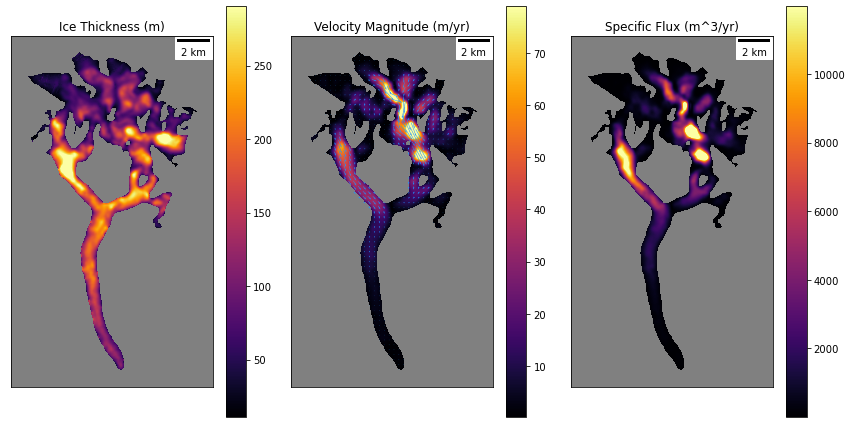

In [48]:
f,axa = plt.subplots(1,3,sharex=True,sharey=True,figsize=(12,6))
axa[0].set_title('Ice Thickness (m)')
imshow_stretch(axa[0],H)
axa[1].set_title('Velocity Magnitude (m/yr)')
imshow_stretch(axa[1],vm)
add_quiver(axa[1],vx,vy)
axa[2].set_title('Specific Flux (m^3/yr)')
imshow_stretch(axa[2],Qm)
plt.tight_layout()

Ice thickness grid contains some artifacts near edges

## Flux divergence

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/b95fd343e0fe05b65d6096aa75a6c0921c33176d)

#### np.gradient

https://numpy.org/doc/stable/reference/generated/numpy.gradient.html

*Note: np.gradient computes derivatives relative to axis number, so (dy,dx) corresponod to axes (0,1)*

In [14]:
#Want x-derivative of x component
divQ = np.gradient(Q[0],dx,axis=1) + np.gradient(Q[1],dy,axis=0)

## Velocity divergence

In [15]:
divV = np.gradient(v_col_f*vx,dx,axis=1) + np.gradient(v_col_f*vy,dy,axis=0)

In [16]:
#divVm = np.sqrt(np.gradient(v_col_f*vx)[1]**2 + np.gradient(v_col_f*vy)[0]**2)

## Thickness gradient

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/7a948b9d1165bf36e01ff46716000a06b34dd801)

In [17]:
#Return both dy and dx derivatives
gradH = np.ma.array(np.gradient(H,dx,dy))

In [18]:
#Thickness difference between adjacent cells (not accounting for cell width and height, 30 m)
#gradH = np.ma.array(np.gradient(H,1,1))

In [19]:
#Magnitude
gradHm = np.sqrt(np.sum(gradH**2, axis=0))

## Flux Divergence from Chain Rule

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/d631403ec94c0dd0f96a9cf45d59921b78e173f7)

* Thickness H is a scalar
* Velocity v is a vector (vx, vy)
* Gradient of thickness is a vector
* Divergence of velocity is a scalar

In [20]:
divQ2 = (gradH[1]*v_col_f*vx + gradH[0]*v_col_f*vy) + H*divV

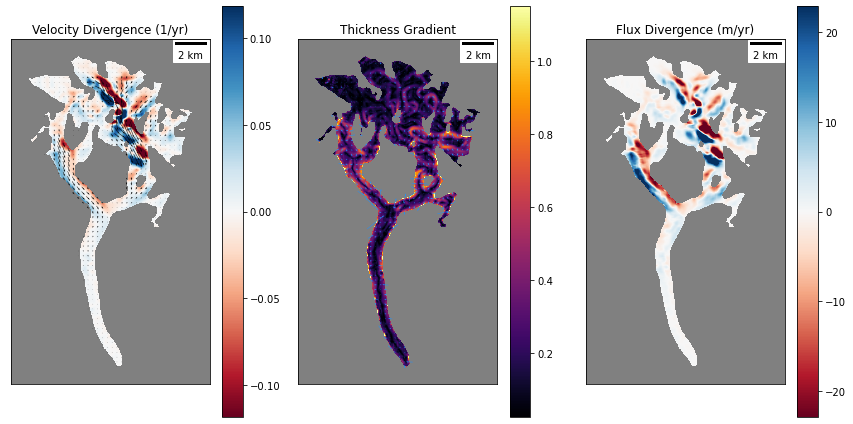

In [60]:
f,axa = plt.subplots(1,3,sharex=True,sharey=True,figsize=(12,6))
axa[0].set_title('Velocity Divergence (1/yr)')
imshow_stretch(axa[0],divV,sym=True)
add_quiver(axa[0],vx,vy,color='k')
axa[1].set_title('Thickness Gradient')
imshow_stretch(axa[1],gradHm)
add_quiver(axa[1],gradH[1],gradH[0])
axa[2].set_title('Flux Divergence (m/yr)')
imshow_stretch(axa[2], divQ2, sym=True)
plt.tight_layout()

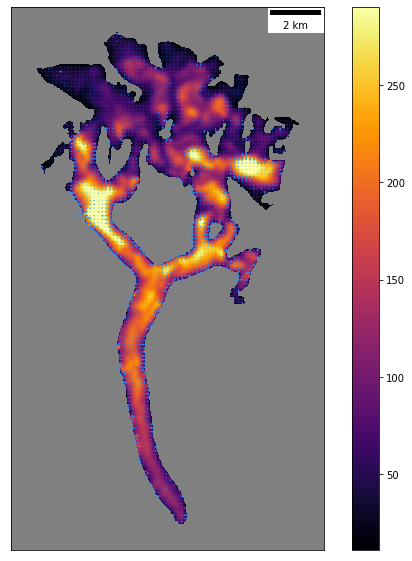

In [49]:
f,ax = plt.subplots(figsize=(10,10))
imshow_stretch(ax,H)
add_quiver(ax,gradH[1],gradH[0],stride=5)

### Check for conservation

In [23]:
divQ2.count()

64317

In [24]:
divQ2.sum()

405.37396

In [25]:
divQ.sum()

442.71863

In [26]:
'%0.2f%% leakage' % (100*divQ2.sum()/divQ2.count())

'0.63% leakage'

## Surface Elevation

In [27]:
gradh = np.ma.array(np.gradient(h,dx,dy))

In [28]:
#Magnitude
gradhm = np.sqrt(np.sum(gradh**2, axis=0))

In [29]:
slope = np.rad2deg(np.arctan(gradhm))

In [30]:
bin_step = 50
bins = np.arange(h.min(),h.max()+bin_step,bin_step)
bin_centers = bins[:-1] + bin_step/2.

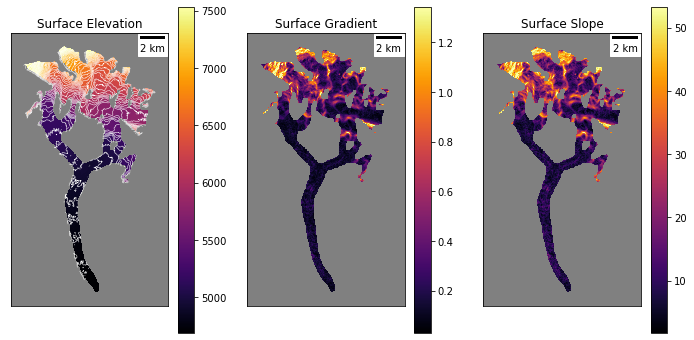

In [61]:
f,axa = plt.subplots(1,3,sharex=True, sharey=True, figsize=(12,6))
axa[0].set_title('Surface Elevation')
imshow_stretch(axa[0],h)
axa[0].contour(h,bins,colors='w',linewidths=0.5)
axa[1].set_title('Surface Gradient')
imshow_stretch(axa[1],gradhm)
axa[2].set_title('Surface Slope')
imshow_stretch(axa[2],slope)

In [55]:
common_mask = np.ma.getmaskarray(np.ma.dstack([h,divQ])).all(axis=-1)
idx = ~common_mask
#f,ax = plt.subplots()
#ax.imshow(idx)

In [56]:
#bin_count = scipy.stats.binned_statistic(h[idx],divQ[idx],statistic='count',bins=bins)
bin_mean = scipy.stats.binned_statistic(h[idx],divQ[idx],statistic='mean',bins=bins)
bin_std = scipy.stats.binned_statistic(h[idx],divQ[idx],statistic='std',bins=bins)

Text(0.5, 0, 'Elevation bin (m)')

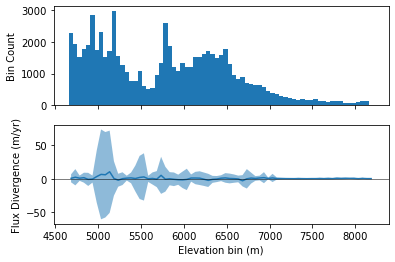

In [57]:
f,axa = plt.subplots(2,1,sharex=True)
axa[0].hist(h[idx],bins=bins)
axa[0].set_ylabel('Bin Count')
axa[1].plot(bin_centers, bin_mean.statistic)
axa[1].fill_between(bin_centers, bin_mean.statistic+bin_std.statistic, bin_mean.statistic-bin_std.statistic, alpha=0.5)
axa[1].axhline(0,color='k',lw=0.5)
axa[1].set_ylabel('Flux Divergence (m/yr)')
axa[1].set_xlabel('Elevation bin (m)')

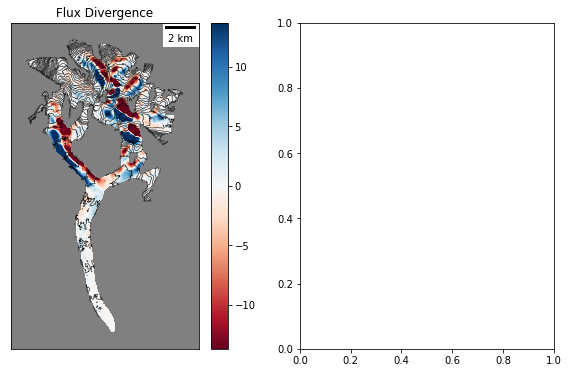

In [62]:
f,axa = plt.subplots(1,2,figsize=(10,6))
axa[0].set_title('Flux Divergence')
imshow_stretch(axa[0],divQ,perc=(5,95),sym=True)
axa[0].contour(h,bins,colors='k',linewidths=0.5);

(-3.0, 3.0)

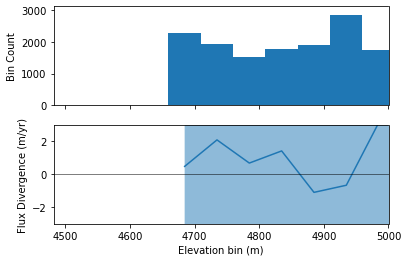

In [59]:
f,axa = plt.subplots(2,1,sharex=True)
axa[0].hist(h[idx],bins=bins)
axa[0].set_ylabel('Bin Count')
axa[1].plot(bin_centers, bin_mean.statistic)
axa[1].fill_between(bin_centers, bin_mean.statistic+bin_std.statistic, bin_mean.statistic-bin_std.statistic, alpha=0.5)
axa[1].axhline(0,color='k',lw=0.5)
axa[1].set_ylabel('Flux Divergence (m/yr)')
axa[1].set_xlabel('Elevation bin (m)')
axa[1].set_xlim(right=5000)
axa[1].set_ylim(-3,3)

(-3, 3)

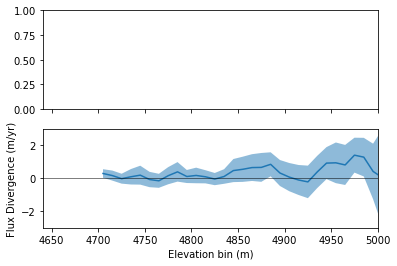

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

bin_step = 10
bins = np.arange(4700,6000+bin_step,bin_step)
bin_centers = bins[:-1] + bin_step/2.
idx = np.arange(0,len(bin_centers))

bin_dr = pd.read_csv('/Users/davidrounce/Documents/Dave_Rounce/DebrisGlaciers_WG/Melt_Intercomparison/output/' + 
                     'mb_bins/csv/15.03473_mb_bins.csv')
f,axa = plt.subplots(2,1,sharex=True)
# axa[0].hist(bin_dr['z1_bin_count_valid'][idx],bins=bins)
# axa[0].set_ylabel('Bin Count')
axa[1].plot(bin_centers, bin_dr['emvel_mean'][idx])
axa[1].fill_between(bin_centers, bin_dr['emvel_mean'][idx]+bin_dr['emvel_std'][idx], 
                    bin_dr['emvel_mean'][idx]-bin_dr['emvel_std'][idx], alpha=0.5)
axa[1].axhline(0,color='k',lw=0.5)
axa[1].set_ylabel('Flux Divergence (m/yr)')
axa[1].set_xlabel('Elevation bin (m)')
axa[1].set_xlim(right=5000)
axa[1].set_ylim(-3,3)